In [15]:
#importing dependencies
import yfinance as yf
import pandas as pd
from scipy import stats
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Bidirectional
from tensorflow.keras.regularizers import l1, l2
from datetime import timezone, datetime as dt

In [2]:
#Gathering Historical Data
# Define the ticker symbol and time period

tickerSymbol = 'BTC-USD'
start_date = '2020-02-14'
end_date = '2023-11-15'

# Fetch the historical data
tickerData = yf.Ticker(tickerSymbol)
tickerDf = tickerData.history(period='1d', start=start_date, end=end_date)

print(tickerDf)

                                   Open          High           Low  \
Date                                                                  
2020-02-14 00:00:00+00:00  10211.550781  10321.996094  10125.534180   
2020-02-15 00:00:00+00:00  10313.856445  10341.555664   9874.427734   
2020-02-16 00:00:00+00:00   9889.179688  10053.968750   9722.386719   
2020-02-17 00:00:00+00:00   9936.560547   9938.815430   9507.637695   
2020-02-18 00:00:00+00:00   9691.230469  10161.935547   9632.382812   
...                                 ...           ...           ...   
2023-11-10 00:00:00+00:00  36702.250000  37493.800781  36362.753906   
2023-11-11 00:00:00+00:00  37310.070312  37407.093750  36773.667969   
2023-11-12 00:00:00+00:00  37133.992188  37227.691406  36779.117188   
2023-11-13 00:00:00+00:00  37070.304688  37405.117188  36399.605469   
2023-11-14 00:00:00+00:00  36491.789062  36753.351562  34948.500000   

                                  Close       Volume  Dividends  Stock Split

In [3]:
# Identifying Missing Data
missing_data = tickerDf.isnull().sum()

# Filling Missing Data (here we fill with the mean, but this is subjective)
tickerDf.fillna(tickerDf.mean(), inplace=True)

print(missing_data)

Open            0
High            0
Low             0
Close           0
Volume          0
Dividends       0
Stock Splits    0
dtype: int64


In [4]:
#Drop the columns we don't need 'Dividends' and 'Stock Splits''
cleaned_tickerDf = tickerDf.drop(columns=['Dividends', 'Stock Splits'])
print(cleaned_tickerDf)

                                   Open          High           Low  \
Date                                                                  
2020-02-14 00:00:00+00:00  10211.550781  10321.996094  10125.534180   
2020-02-15 00:00:00+00:00  10313.856445  10341.555664   9874.427734   
2020-02-16 00:00:00+00:00   9889.179688  10053.968750   9722.386719   
2020-02-17 00:00:00+00:00   9936.560547   9938.815430   9507.637695   
2020-02-18 00:00:00+00:00   9691.230469  10161.935547   9632.382812   
...                                 ...           ...           ...   
2023-11-10 00:00:00+00:00  36702.250000  37493.800781  36362.753906   
2023-11-11 00:00:00+00:00  37310.070312  37407.093750  36773.667969   
2023-11-12 00:00:00+00:00  37133.992188  37227.691406  36779.117188   
2023-11-13 00:00:00+00:00  37070.304688  37405.117188  36399.605469   
2023-11-14 00:00:00+00:00  36491.789062  36753.351562  34948.500000   

                                  Close       Volume  
Date                 

In [5]:
#Push yfinance data into a .csv to enable the date column to become workable.

base_name1 = "extract_Test1.csv"

cleaned_tickerDf.to_csv(base_name1,index=True)    #df.to_csv(csv_file_path, index=False) )

In [6]:
#re-import csv to a Pandas dataframe
import os
from pathlib import Path

__file__ = "proj4_predictive_nn_yfinance_BTC.ipynb"

script_abs_path = os.path.abspath(__file__)   #FINDS => Full FILEPATH to this EXACT ".py" or ".ipynb" file .... 
print(script_abs_path)
script_dir_name = os.path.dirname(script_abs_path)  #FINDS => PARENT FOLDER ... this EXACT ".py" or ".ipynb" file ....
print(script_dir_name)
print("-----")
os.chdir(script_dir_name)

#Confirm actual Current Directory for Building out Path.
validated_current_dir = os.getcwd()
print(validated_current_dir)

csv_file_path = str(validated_current_dir) + "\\" + str(base_name1)

print(csv_file_path)


c:\Users\Aolda\onedrive\desktop\SCS_Modules_ToGitHub\Group2_Project4\proj4_predictive_nn_yfinance_BTC.ipynb
c:\Users\Aolda\onedrive\desktop\SCS_Modules_ToGitHub\Group2_Project4
-----
c:\Users\Aolda\onedrive\desktop\SCS_Modules_ToGitHub\Group2_Project4
c:\Users\Aolda\onedrive\desktop\SCS_Modules_ToGitHub\Group2_Project4\extract_Test1.csv


In [7]:
y_finance_analysis_df = pd.read_csv(csv_file_path)

y_finance_analysis_df.head(13)

,Date,Open,High,Low,Close,Volume
0,2020-02-14 00:00:00+00:00,10211.550781,10321.996094,10125.534180,10312.116211,43338264162
1,2020-02-15 00:00:00+00:00,10313.856445,10341.555664,9874.427734,9889.424805,43865054831
2,2020-02-16 00:00:00+00:00,9889.179688,10053.968750,9722.386719,9934.433594,43374780305
3,2020-02-17 00:00:00+00:00,9936.560547,9938.815430,9507.637695,9690.142578,45998298413
4,2020-02-18 00:00:00+00:00,9691.230469,10161.935547,9632.382812,10141.996094,47271023953
5,2020-02-19 00:00:00+00:00,10143.798828,10191.675781,9611.223633,9633.386719,46992019710
6,2020-02-20 00:00:00+00:00,9629.325195,9643.216797,9507.900391,9608.475586,44925260237
7,2020-02-21 00:00:00+00:00,9611.782227,9723.014648,9589.743164,9686.441406,40930547513
8,2020-02-22 00:00:00+00:00,9687.707031,9698.231445,9600.728516,9663.181641,35838025154
9,2020-02-23 00:00:00+00:00,9663.318359,9937.404297,9657.791016,9924.515625,41185185761


In [8]:
y_finance_analysis_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1370 entries, 0 to 1369
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1370 non-null   object 
 1   Open    1370 non-null   float64
 2   High    1370 non-null   float64
 3   Low     1370 non-null   float64
 4   Close   1370 non-null   float64
 5   Volume  1370 non-null   int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 64.3+ KB


In [9]:
y_finance_analysis_df["Date"] = pd.to_datetime(pd.to_datetime(y_finance_analysis_df["Date"], format='%Y-%m-%d').astype("string"))  #.dt.date)

print(y_finance_analysis_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1370 entries, 0 to 1369
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype              
---  ------  --------------  -----              
 0   Date    1370 non-null   datetime64[ns, UTC]
 1   Open    1370 non-null   float64            
 2   High    1370 non-null   float64            
 3   Low     1370 non-null   float64            
 4   Close   1370 non-null   float64            
 5   Volume  1370 non-null   int64              
dtypes: datetime64[ns, UTC](1), float64(4), int64(1)
memory usage: 64.3 KB
None


In [10]:
y_finance_analysis_df.tail(15)

,Date,Open,High,Low,Close,Volume
1355,2023-10-31 00:00:00+00:00,34500.078125,34719.253906,34083.308594,34667.781250,15758270810
1356,2023-11-01 00:00:00+00:00,34657.273438,35527.929688,34170.691406,35437.253906,22446272005
1357,2023-11-02 00:00:00+00:00,35441.578125,35919.843750,34401.574219,34938.242188,20998158544
1358,2023-11-03 00:00:00+00:00,34942.472656,34942.472656,34133.441406,34732.324219,17158456701
1359,2023-11-04 00:00:00+00:00,34736.324219,35256.031250,34616.691406,35082.195312,9561294264
1360,2023-11-05 00:00:00+00:00,35090.011719,35340.339844,34594.242188,35049.355469,12412743996
1361,2023-11-06 00:00:00+00:00,35044.789062,35286.027344,34765.363281,35037.371094,12693436420
1362,2023-11-07 00:00:00+00:00,35047.792969,35892.417969,34545.816406,35443.562500,18834737789
1363,2023-11-08 00:00:00+00:00,35419.476562,35994.417969,35147.800781,35655.277344,17295394918
1364,2023-11-09 00:00:00+00:00,35633.632812,37926.257812,35592.101562,36693.125000,37762672382


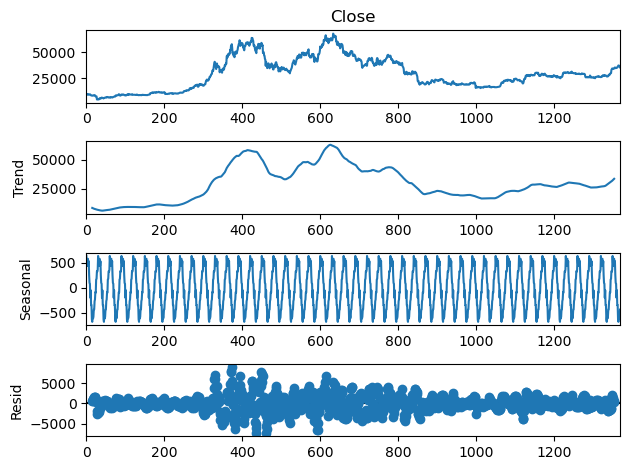

C:\Users\Aolda\AppData\Local\Temp\ipykernel_7052\2781230731.py:7: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(y_finance_analysis_df.corr(), annot=True, cmap='coolwarm')


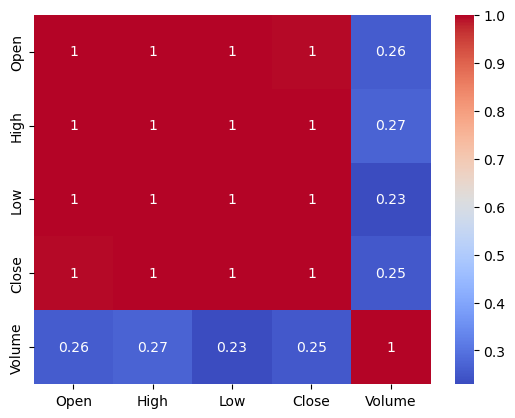

In [11]:
# Time Series Decomposition Plots
decomposition = seasonal_decompose(y_finance_analysis_df['Close'], model='additive', period=30)
decomposition.plot()
plt.show()

# Correlation Heatmaps
sns.heatmap(y_finance_analysis_df.corr(), annot=True, cmap='coolwarm')

#Set x-ticks to "date" column ... (future fix)

plt.show()

NameError: name 'y_finance_analysis_d' is not defined

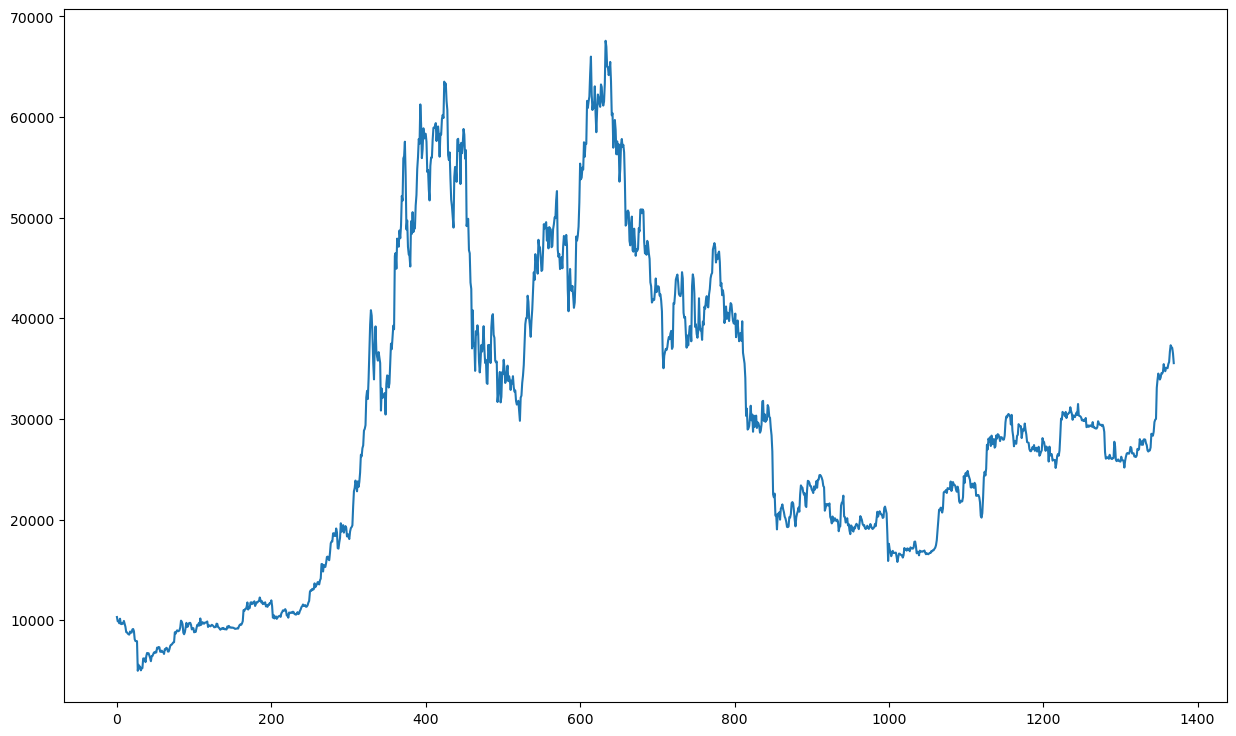

In [38]:
price = y_finance_analysis_df[['Close']]

plt.figure(figsize = (15,9))
plt.plot(price)
plt.xticks(range(0, y_finance_analysis_d.shape[0],50), y_finance_analysis_d['Date'].loc[::50],rotation=45)
plt.title("Bitcoin Price",fontsize=18, fontweight='bold')
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price (USD)',fontsize=18)
plt.show()

# Totally random info below ... can be deleted but will save a backup copy ... 

In [ ]:
from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler()

norm_data = min_max_scaler.fit_transform(price.values)

In [16]:
today = dt.today().date()   #strftime('%Y-%m-%d')

print(today)
print(type(today))

2023-11-16
<class 'datetime.date'>


In [22]:

today_timestamp = pd.Timestamp(today)



# Replace the timezone information with None to make both timezone-naive
naive_datetime1 = today_timestamp.replace(tzinfo=timezone.utc)
naive_datetime2 = y_finance_analysis_df["Date"]#.replace(tzinfo=None)

In [23]:
# Print out the timezone information of the 'DatetimeColumn'
print("\nTimezone information of 'DatetimeColumn':")
print(y_finance_analysis_df["Date"].dt.tz)


Timezone information of 'DatetimeColumn':
UTC


In [30]:
today_timestamp = pd.Timestamp(today)

y_finance_analysis_df["Date_Difference_Today"] = (naive_datetime1 - naive_datetime2).dt.total_seconds().astype("float")

y_finance_analysis_df["Date_Difference_Today"] = pd.to_timedelta(y_finance_analysis_df["Date_Difference_Today"], unit='s').dt.days.astype("float")


y_finance_analysis_df.head()

# Create a timezone-aware datetime object
#aware_datetime = datetime(2023, 1, 1, tzinfo=timezone.utc)

# Create another timezone-aware datetime object with a different timezone
#another_aware_datetime = datetime(2023, 1, 1, tzinfo=timezone(timedelta(hours=3)))

# Replace the timezone information with None to make both timezone-naive
#naive_datetime1 = aware_datetime.replace(tzinfo=None)
#naive_datetime2 = another_aware_datetime.replace(tzinfo=None)

# Perform operations with the timezone-naive datetimes
#result = naive_datetime1 - naive_datetime2

# Display the result
#print(result)

,Date,Open,High,Low,Close,Volume,Date_Difference_Today
0,2020-02-14 00:00:00+00:00,10211.550781,10321.996094,10125.534180,10312.116211,43338264162,1371.0
1,2020-02-15 00:00:00+00:00,10313.856445,10341.555664,9874.427734,9889.424805,43865054831,1370.0
2,2020-02-16 00:00:00+00:00,9889.179688,10053.968750,9722.386719,9934.433594,43374780305,1369.0
3,2020-02-17 00:00:00+00:00,9936.560547,9938.815430,9507.637695,9690.142578,45998298413,1368.0
4,2020-02-18 00:00:00+00:00,9691.230469,10161.935547,9632.382812,10141.996094,47271023953,1367.0


In [31]:
print(y_finance_analysis_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1370 entries, 0 to 1369
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype              
---  ------                 --------------  -----              
 0   Date                   1370 non-null   datetime64[ns, UTC]
 1   Open                   1370 non-null   float64            
 2   High                   1370 non-null   float64            
 3   Low                    1370 non-null   float64            
 4   Close                  1370 non-null   float64            
 5   Volume                 1370 non-null   int64              
 6   Date_Difference_Today  1370 non-null   float64            
dtypes: datetime64[ns, UTC](1), float64(5), int64(1)
memory usage: 75.1 KB
None


In [33]:

y_finance_analysis_df["Date"] = y_finance_analysis_df["Date"].astype("string")  #.dt.date)

print(y_finance_analysis_df.info())
print(y_finance_analysis_df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1370 entries, 0 to 1369
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Date                   1370 non-null   string 
 1   Open                   1370 non-null   float64
 2   High                   1370 non-null   float64
 3   Low                    1370 non-null   float64
 4   Close                  1370 non-null   float64
 5   Volume                 1370 non-null   int64  
 6   Date_Difference_Today  1370 non-null   float64
dtypes: float64(5), int64(1), string(1)
memory usage: 75.1 KB
None
                        Date          Open          High           Low  \
0  2020-02-14 00:00:00+00:00  10211.550781  10321.996094  10125.534180   
1  2020-02-15 00:00:00+00:00  10313.856445  10341.555664   9874.427734   
2  2020-02-16 00:00:00+00:00   9889.179688  10053.968750   9722.386719   
3  2020-02-17 00:00:00+00:00   9936.560547   9938.815430   9507

In [36]:
# Predictor Identification
# Note: This is more about forming hypotheses and identifying potential predictors based on domain knowledge and initial analysis.

# Theory Testing - Example with Simple Linear Regression
from sklearn.linear_model import LinearRegression #PCA can be a second option ... 
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Assuming we want to predict 'Close' using 'Volume' (as an example)
X_features = y_finance_analysis_df[["Date_Difference_Today", "High", "Volume"]]  #,"Close", "Volume"]]   #["High","Volume"]]    #lin_reg_df  #[   #features_col_names_fetched2]
y_target = y_finance_analysis_df["Close"]   #lin_ref_target

# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.2, random_state=0)

# Creating a linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predicting and evaluating the model
y_predictions = model.predict(X_test)
print("Mean Squared Error:", mean_squared_error(y_test, y_predictions))

Mean Squared Error: 426181.7316953222
